In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

from textblob import TextBlob

from tqdm import tqdm_notebook as tqdm
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

C:\Users\HP\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\HP\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [2]:
df1 = pd.read_csv('ethiopia_tripadvisor_data_model_3.csv')
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"['Amazing', 'location', 'must', 'visit.']"
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"['I', 'do', 'recommend', 'to', 'visit', 'Lalib..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"['A', 'must', 'visit', 'in', 'Ethiopia', '-', ..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"['These', 'churches', 'have', 'to', 'be', 'see..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"['Thanks', 'to', 'our', 'tour', 'organiser', '..."


In [3]:
df1['RH_Split'] = df1['Review Head'].apply(lambda x: x.split(' '))
df1['RB_Split'] = df1['Review Body'].apply(lambda x: x.split(' '))
df1['RT_Split'] = df1['Review Text'].apply(lambda x: x.split(' '))
df1['RB_Sentence1_Split'] = df1['RB_Sentence1'].apply(lambda x: x.split(' '))
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split,RH_Split,RB_Split,RT_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"[Amazing, location, must, visit.]","[Incredible, locations, don't, be, put, off, t...","[Amazing, location, must, visit., This, site, ...","[Incredible, locations, don't, be, put, off, t..."
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!]","[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!, I,..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, ]","[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, A, must, visit, in, E..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"[These, churches, have, to, be, seen, to, be, ...",[Amazing],"[These, churches, have, to, be, seen, to, be, ...","[Amazing, These, churches, have, to, be, seen,..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history]","[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history, Thanks, to, our, tour, org..."


In [4]:
df1['Destination Type'].value_counts()

Landmarks       3803
Museums         2507
Nature/Parks    2001
Name: Destination Type, dtype: int64

### Topic Modelling

In [5]:
# NLTK Stop words
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

test_subset = df1['RH_Split'].values
sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for value in test_subset:
    for word in value:
        if (sid.polarity_scores(word)['compound']) >= 0.4:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <= -0.4:
            print
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)                

print('Positive :', len(pos_word_list))       
print('Neutral :', len(neu_word_list))    
print('Negative :', len(neg_word_list))

Positive : 4118
Neutral : 35704
Negative : 326


In [6]:
from nltk.corpus import stopwords

main_stop_words = ['ethiopia', 'ethiopian', 'rock', 'hewn', 'church', 'churches', 'park', 'parks', 'museum', 
                       'museums', 'omo', 'valley', 'mountain', 'mountains', 'addis', 'ababa', 'lucy', 'simien', 
                       'national', 'lalibela', 'gelada', 'haile', 'selassie', 'gondar', 'africa' , 'harar', 
                       'cathedral', 'cathedrals', 'place', 'visit', 'girmay', 
                       '\n', '‘s']
positive_stop_words = list(set(pos_word_list))
negative_stop_words = list(set(neg_word_list))
total_stop_words = main_stop_words + positive_stop_words + negative_stop_words

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(total_stop_words)
print('Stop Words: ', len(stop_words))

Stop Words:  862


In [7]:
# Convert to list
data = df1[df1['Destination Type'] == 'Landmarks'][df1['TextBlob Polarity Head'] > 0]['Review Head'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['It is a real miracle of the world!']


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['it', 'is', 'real', 'miracle', 'of', 'the', 'world']]


In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['it', 'is', 'real', 'miracle', 'of', 'the', 'world']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['real', 'world']]


In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('real', 1), ('world', 1)]]

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.126*"experience" + 0.123*"see" + 0.096*"painting" + 0.078*"religious" + '
  '0.048*"visit" + 0.047*"view" + 0.039*"unique" + 0.025*"spectacular" + '
  '0.023*"quite" + 0.020*"magical"'),
 (1,
  '0.145*"site" + 0.070*"important" + 0.063*"really" + 0.053*"historical" + '
  '0.038*"building" + 0.027*"colorful" + 0.025*"construction" + 0.021*"high" + '
  '0.021*"always" + 0.018*"holy"'),
 (2,
  '0.103*"architecture" + 0.094*"walk" + 0.062*"look" + 0.050*"cave" + '
  '0.045*"monastery" + 0.028*"climb" + 0.023*"make" + 0.020*"alone" + '
  '0.020*"unexpected" + 0.018*"natural"'),
 (3,
  '0.096*"stunning" + 0.071*"small" + 0.053*"cool" + 0.045*"example" + '
  '0.044*"mural" + 0.041*"bit" + 0.035*"pay" + 0.032*"absolutely" + '
  '0.032*"ceiling" + 0.030*"photo"'),
 (4,
  '0.184*"history" + 0.117*"guide" + 0.087*"old" + 0.038*"much" + '
  '0.026*"people" + 0.026*"get" + 0.019*"person" + 0.017*"piece" + '
  '0.016*"religion" + 0.016*"lose"'),
 (5,
  '0.088*"go" + 0.073*"incredible" + 0.

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.2703001407341565

Coherence Score:  0.6699898455835933


In [17]:
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

In [18]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
os.environ.update({'MALLET_HOME':r'C:/Users/HP/mallet-2.0.8/'})
mallet_path = r'C:\Users\HP\mallet-2.0.8\bin\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word, random_seed = 1)

In [19]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('guide', 0.18218623481781376),
   ('tour', 0.16194331983805668),
   ('religious', 0.07692307692307693),
   ('top', 0.06072874493927125),
   ('city', 0.05263157894736842),
   ('part', 0.032388663967611336),
   ('spot', 0.032388663967611336),
   ('absolutely', 0.032388663967611336),
   ('huge', 0.016194331983805668),
   ('person', 0.016194331983805668)]),
 (1,
  [('unique', 0.09505703422053231),
   ('architecture', 0.053231939163498096),
   ('ancient', 0.053231939163498096),
   ('structure', 0.04182509505703422),
   ('full', 0.04182509505703422),
   ('cool', 0.03802281368821293),
   ('main', 0.034220532319391636),
   ('astonish', 0.034220532319391636),
   ('town', 0.030418250950570342),
   ('worth', 0.022813688212927757)]),
 (2,
  [('site', 0.29707112970711297),
   ('building', 0.07112970711297072),
   ('walk', 0.06276150627615062),
   ('holy', 0.029288702928870293),
   ('mural', 0.02510460251046025),
   ('destination', 0.02510460251046025),
   ('extraordinary', 0.02510460251046

2
3
4
5
6
7
8
9
10


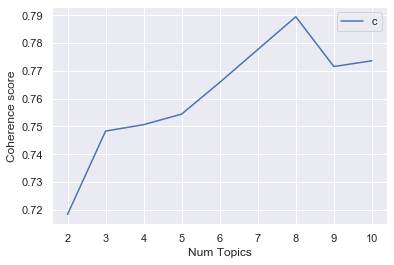

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, 
                                                 random_seed = 1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

start1 = 2 
limit1 = 11
step1 = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start1, limit=limit1, step=step1)

x = range(start1, limit1, step1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [21]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.7183
Num Topics = 3  has Coherence Value of 0.7483
Num Topics = 4  has Coherence Value of 0.7507
Num Topics = 5  has Coherence Value of 0.7545
Num Topics = 6  has Coherence Value of 0.7659
Num Topics = 7  has Coherence Value of 0.7777
Num Topics = 8  has Coherence Value of 0.7895
Num Topics = 9  has Coherence Value of 0.7716
Num Topics = 10  has Coherence Value of 0.7737


In [22]:
optimal_model = model_list[6] # Number of Topics = 8

# optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.391*"worth" + 0.062*"small" + 0.049*"top" + 0.046*"important" + '
  '0.033*"drive" + 0.030*"stone" + 0.030*"absolutely" + 0.026*"colorful" + '
  '0.013*"spectacular" + 0.010*"image"'),
 (1,
  '0.127*"stunning" + 0.102*"architecture" + 0.079*"unique" + 0.054*"building" '
  '+ 0.035*"miss" + 0.025*"preserve" + 0.019*"monument" + 0.019*"ride" + '
  '0.016*"wall" + 0.016*"overprice"'),
 (2,
  '0.137*"guide" + 0.122*"site" + 0.076*"historical" + 0.058*"historic" + '
  '0.030*"people" + 0.027*"astonish" + 0.024*"make_sure" + 0.021*"location" + '
  '0.021*"holy" + 0.018*"culture"'),
 (3,
  '0.205*"experience" + 0.077*"day" + 0.068*"visit" + 0.040*"ancient" + '
  '0.031*"structure" + 0.028*"unforgettable" + 0.026*"important" + '
  '0.023*"spiritual" + 0.023*"part" + 0.020*"piece"'),
 (4,
  '0.120*"trip" + 0.047*"magical" + 0.043*"city" + 0.040*"climb" + '
  '0.037*"full" + 0.033*"long" + 0.027*"ceiling" + 0.027*"real" + 0.027*"spot" '
  '+ 0.023*"lot"'),
 (5,
  '0.124*"tour" + 0.115*

In [39]:
optimal_model2 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model2, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.141253 -0.224817       1        1  12.558847
2     -0.263244 -0.171915       2        1  12.552172
3      0.223028  0.033467       3        1  12.510518
5     -0.286997 -0.010539       4        1  12.508276
6     -0.131231  0.238070       5        1  12.485559
4      0.094720 -0.190130       6        1  12.483959
1      0.053094  0.257397       7        1  12.451036
0      0.169376  0.068467       8        1  12.449634, topic_info=    Category        Freq          Term       Total  loglift  logprob
61   Default  146.000000         worth  146.000000  30.0000  30.0000
4    Default  101.000000       history  101.000000  29.0000  29.0000
2    Default   77.000000    experience   77.000000  28.0000  28.0000
3    Default   60.000000    incredible   60.000000  27.0000  27.0000
44   Default   89.000000          site   89.000000  26.0000  26.0000
11   Default   51.000000         guide   51.000000  25.0000  25.0000
13   Default   46.000000          tour   46.000000  24.0000  24.0000
60   Default   45.000000          trip   45.000000  23.0000  23.0000
59   Default   54.000000      stunning   54.000000  22.0000  22.0000
72   Default   40.000000  architecture   40.000000  21.0000  21.0000
1    Default   30.000000         world   30.000000  20.0000  20.0000
40   Default   29.000000        unique   29.000000  19.0000  19.0000
6    Default   28.000000           day   28.000000  18.0000  18.0000
110  Default   28.000000    historical   28.000000  17.0000  17.0000
366  Default   40.000000      painting   40.000000  16.0000  16.0000
36   Default   25.000000         visit   25.000000  15.0000  15.0000
149  Default   23.000000         small   23.000000  14.0000  14.0000
265  Default   25.000000          view   25.000000  13.0000  13.0000
58   Default   22.000000     religious   22.000000  12.0000  12.0000
49   Default   21.000000      historic   21.000000  11.0000  11.0000
327  Default   20.000000      building   20.000000  10.0000  10.0000
124  Default   19.000000          time   19.000000   9.0000   9.0000
39   Default   18.000000           top   18.000000   8.0000   8.0000
112  Default   26.000000     important   26.000000   7.0000   7.0000
96   Default   17.000000       magical   17.000000   6.0000   6.0000
62   Default   15.000000         local   15.000000   5.0000   5.0000
341  Default   17.000000          city   17.000000   4.0000   4.0000
225  Default   18.000000          walk   18.000000   3.0000   3.0000
349  Default   15.000000         climb   15.000000   2.0000   2.0000
55   Default   14.000000       ancient   14.000000   1.0000   1.0000
..       ...         ...           ...         ...      ...      ...
147   Topic8    1.234316     knowledge    1.234316   2.0835  -5.7170
149   Topic8   23.451997         small   23.451997   2.0835  -2.7726
632   Topic8    9.874525      colorful    9.874525   2.0835  -3.6376
652   Topic8    3.702947          boat    3.702947   2.0835  -4.6184
811   Topic8    2.468631         heart    2.468631   2.0835  -5.0239
552   Topic8    2.468631      surprise    2.468631   2.0835  -5.0239
182   Topic8    2.468631     architect    2.468631   2.0835  -5.0239
171   Topic8    1.234316      describe    1.234316   2.0835  -5.7170
733   Topic8    1.234316         color    1.234316   2.0835  -5.7170
636   Topic8    1.234316       luckily    1.234316   2.0835  -5.7170
468   Topic8    1.234316          meet    1.234316   2.0835  -5.7170
761   Topic8    1.234316   challenging    1.234316   2.0835  -5.7170
622   Topic8    1.234316          plot    1.234316   2.0835  -5.7170
618   Topic8    1.234316      homework    1.234316   2.0835  -5.7170
729   Topic8    1.234316      climbing    1.234316   2.0835  -5.7170
719   Topic8    1.234316      begining    1.234316   2.0835  -5.7170
647   Topic8    1.234316     transform    1.234316   2.0835  -5.7170
106   Topic8   11.108841    absolute

In [23]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7.0,0.1394,"incredible, world, time, walk, modern, spectac...",It is a real miracle of the world!
1,1,3.0,0.1394,"experience, day, visit, ancient, structure, un...",Incredible experience
2,2,0.0,0.1250,"worth, small, top, important, drive, stone, ab...",Amazing
3,3,6.0,0.1422,"history, painting, local, simply, cool, stop, ...",So much history
4,4,0.0,0.1250,"worth, small, top, important, drive, stone, ab...",Just WoW and Amazing !!
5,5,0.0,0.1250,"worth, small, top, important, drive, stone, ab...",Amazing
6,6,0.0,0.1250,"worth, small, top, important, drive, stone, ab...",wonderful place
7,7,2.0,0.1368,"guide, site, historical, historic, people, ast...",Impressive and unexpected - 2 days 1 night
8,8,2.0,0.1389,"guide, site, historical, historic, people, ast...",One of the Best and economical tour guides in ...
9,9,5.0,0.1422,"tour, site, view, religious, cave, painting, f...",Great tour of Lalibela churches with Henok


In [24]:
df_dominant_topic['Dominant_Topic'].value_counts()

0.0    1148
1.0     197
3.0     177
2.0     171
6.0     153
7.0     143
5.0     138
4.0     135
Name: Dominant_Topic, dtype: int64

In [25]:
df_dominant_topic.to_csv('ethiopia_412.csv', index = False)

In [42]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

# Run 2

# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # Topicless/Unidentifiable - 1148
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Appreciation with caveat (Expensive Fees) - 197
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # Tour Guide - 171
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # History Appreciation - 177
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # Visual (Architecture, Paintings, etc.) - 135
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # Visual (Architecture, Paintings, etc.) - 138
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values # History Appreciation - 153
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7]['Text'].values # Topicless/Unidentifiable - 143

In [36]:
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)

# Run 1

# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # General Appreciation - 1123
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Visual (Aesthetic, Paintings, etc.) - 200
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # Appreciation of History - 182
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # Visual (Aesthetic, Paintings, etc.) - 180
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # General Appreciation - 169
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # Appreciation with caveat (Expensive Fees) - 162
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values # Tour Guide - 115
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7]['Text'].values # General Appreciation - 131

In [36]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1682,"worth, small, top, important, drive, stone, ab...",Stone-hewn church a couple of hours out of Add...
1,1.0,0.1745,"stunning, architecture, unique, building, miss...","Awesome, but costly given 50USD entrance fee"
2,2.0,0.1691,"guide, site, historical, historic, people, ast...",Great very important historic site declared as...
3,3.0,0.1601,"experience, day, visit, ancient, structure, un...","A good option, if you have additional half-day..."
4,4.0,0.1713,"trip, magical, city, climb, full, long, ceilin...",Long Trip but not as long as its interesting h...
5,5.0,0.1703,"tour, site, view, religious, cave, painting, f...",Significant religious site.
6,6.0,0.1603,"history, painting, local, simply, cool, stop, ...",sheer climb to amazingly preserved medieval wa...
7,7.0,0.1703,"incredible, world, time, walk, modern, spectac...",Wait until you walk inside - wow!


In [37]:
sent_topics_sorteddf_mallet['Text'].values

array(['Stone-hewn church a couple of hours out of Addis - worth a visit on market day',
       'Awesome, but costly given 50USD entrance fee',
       'Great very important historic site declared as world heritage site by Unesco',
       'A good option, if you have additional half-day on your hands',
       'Long Trip but not as long as its interesting history',
       'Significant religious site.',
       'sheer climb to amazingly preserved medieval wall painting',
       'Wait until you walk inside - wow!'], dtype=object)

In [38]:
# # Number of Documents for Each Topic
# topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# # Percentage of Documents for Each Topic
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# # Topic Number and Keywords
# topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# # Concatenate Column wise
# df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# # Change Column names
# df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# # Show
# df_dominant_topics